# Binary Classification

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
heart = pd.read_csv('heart_disease.csv')

## Initial EDA / Preprocessing

In [94]:
heart.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca             object
thal           object
present         int64
dtype: object

In [95]:
heart.drop('Unnamed: 0', axis=1, inplace=True)

In [96]:
heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
    }
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
present,,,,,,,,,,,
0,52.585366,0.560976,2.792683,129.250000,242.640244,0.140244,0.835366,158.378049,0.140244,0.586585,1.408537
1,56.625899,0.820144,3.589928,134.568345,251.474820,0.158273,1.172662,139.258993,0.546763,1.574101,1.827338


### By Sex

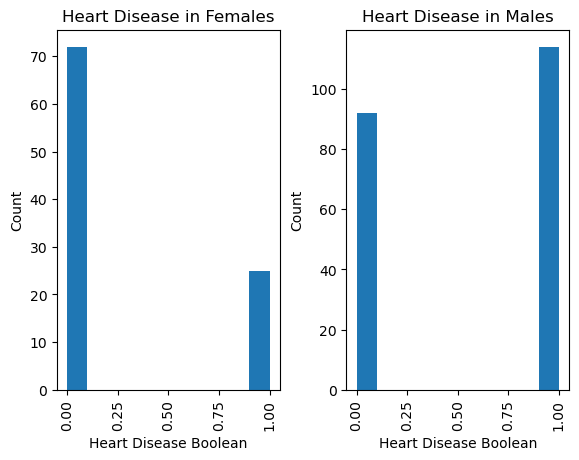

In [97]:
heart.hist(column='present', by='sex')
axes = plt.gcf().get_axes()
for i, ax in enumerate(axes):
    sex = 'Males' if i == 1 else 'Females'
    axes[i].set_title(f'Heart Disease in {sex}')
    axes[i].set_xlabel('Heart Disease Boolean')
    axes[i].set_ylabel('Count')

It looks like males have high rates of HD compared to women, this seems to be a promising predictor of heart disease.

### By Serum Cholesterol

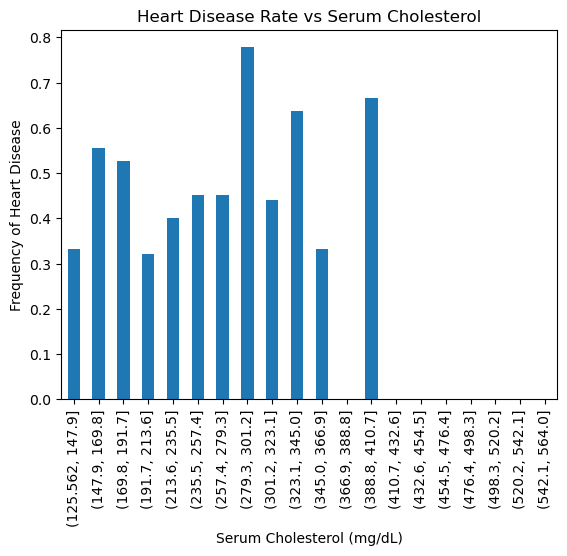

In [98]:
heart['chol_bins'] = pd.cut(heart['chol'],bins=20)
chol_bin_counts = heart.groupby('chol_bins')['present'].mean()
chol_bin_counts.plot(kind='bar')
plt.xlabel('Serum Cholesterol (mg/dL)')
plt.ylabel('Frequency of Heart Disease')
plt.title('Heart Disease Rate vs Serum Cholesterol')
plt.show()

We see a slight positive correlation between HD frequency and serum cholesterol, however less than perhaps expected. This may be a potential predictor.

### By Resting Blood Pressure

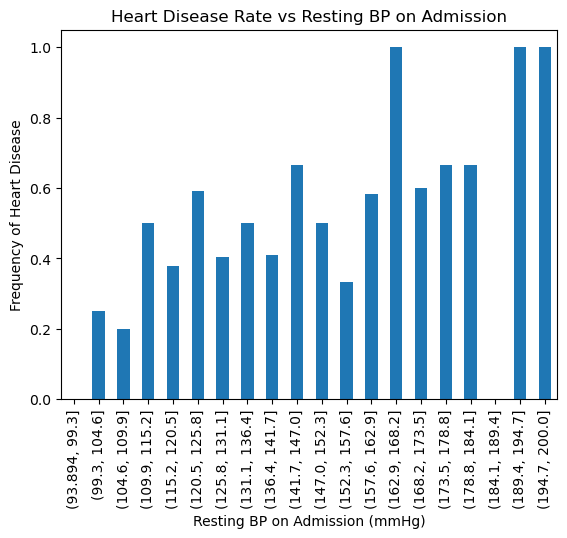

In [99]:
heart['trest_bins'] = pd.cut(heart['trestbps'], bins=20)
trest_bin_counts = heart.groupby('trest_bins')['present'].mean()
trest_bin_counts.plot(kind='bar')
plt.xlabel('Resting BP on Admission (mmHg)')
plt.ylabel('Frequency of Heart Disease')
plt.title('Heart Disease Rate vs Resting BP on Admission')
plt.show()

Resting BP on admission appears to be a strong predictor for HD. We see a strong positive correlation between the two.

### EDA Notes
1. Let's use Sex, Age, Resting BP on Admission (trestbps), resting electrocardiograph (restecg) as predictors for our model. Below let's drop the bin columns as well/

In [100]:
heart.drop(['chol_bins','trest_bins'],axis=1, inplace=True)

## Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = heart[['age','sex','trestbps','restecg']]
y = heart['present']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
model = LogisticRegression()

model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
print(train_score)

predictions = model.predict(X_train)
fp = sum((y_train==0) & (predictions==1))
fn = sum((y_train==1) & (predictions==0))
tp = sum((y_train==1) & (predictions==1))
tn = sum((y_train==0) & (predictions==0))

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print(sensitivity,specificity)

0.6570247933884298
0.5420560747663551 0.7481481481481481


### Model Coefficients

In [115]:
predictors = ['age','sex','trestbps','restecg']

#log odds
for pred, val in zip(predictors, model.coef_[0]):
    print(pred, ":", round(val, 2))
    
#probability
for pred, val in zip(predictors, model.coef_[0]):
    print(pred, ":", round(np.exp(val), 2))

age : 0.06
sex : 1.41
trestbps : 0.01
restecg : 0.3
age : 1.07
sex : 4.08
trestbps : 1.01
restecg : 1.35


### Test Set Evaluations

In [116]:
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)
     

Test Accuracy:  0.6065573770491803
Test Sensitivity:  0.53125
Test Specificity:  0.6896551724137931


This model performed worse on the test set vs. the training set, suggesting that we may have overfit our model on the training set. We see that in particular, the specificity dropped more than the sensitivity. Our model likely fit too well to noise or patterns in the training data that did not generalize well to newer data such as in the test set. We may want to redo our model, seeing that the log odds of sex are much higher than the log odds of the other three predictors. 